#  Here, I calculate one hour prediction by Ensemble Kalman Filter 

### Install weather data to predict

In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import os
import matplotlib.pyplot as plt
from pylab import rcParams

plt.style.use('ggplot')
%pylab inline --no-import-all

#インプットデータ
input_data = pd.read_csv('hakata_ekimae_2017_data_from_meteoblue.csv')
#temp = temp.drop("気温(℃).1",axis=1)
#temp = temp.drop("気温(℃).2" ,axis=1)

#列名の変更
input_data.columns = ['Year', 'Month', 'Day','Hour', 'Minute','Temperature(2m)', 'Mean Sea Level Pressure[hpa]', \
                      'Shortwave Radiation[W/m2]','Wind Speed(10m)[m/s]','Wind Direction(10m)' ,'Wind Speed(80m)[m/s]'\
              , 'Wind Direction(80m)']

#日付型などの変更
input_data['Date'] = input_data[['Year', 'Month', 'Day']].apply(lambda x: '{}@{}@{}'.format(x[0], x[1], x[2]), axis=1)
Date = input_data['Date']
input_data['Date'] =pd.to_datetime(Date, format='%Y@%m@%d')

input_data['Time'] = input_data[['Year', 'Month', 'Day','Hour']].apply(lambda x: '{}@{}@{}@{}'.format(x[0], x[1], x[2],x[3]), axis=1)
Time = input_data['Time']
input_data['Time'] =pd.to_datetime(Time, format='%Y@%m@%d@%H')

#number日分を抽出
number=7
ThreeDays = input_data[:24*number+1]
ThreeDays = ThreeDays.loc[:,['Hour', 'Temperature(2m)', 'Wind Speed(80m)[m/s]']]

#時間　気温　日射量をarray型でそれぞれ格納
Hour = ThreeDays['Hour'].values
Temperature = ThreeDays['Temperature(2m)'].values
Wind = ThreeDays['Wind Speed(80m)[m/s]'].values

Time = input_data['Time'][:24*number+1]

ThreeDays[:15]

Populating the interactive namespace from numpy and matplotlib


,Hour,Temperature(2m),Wind Speed(80m)[m/s]
0,0,3.38,0.92
1,1,3.39,1.00
2,2,3.45,1.03
3,3,2.98,0.70
4,4,2.49,1.26
5,5,2.25,1.34
6,6,1.89,1.92
7,7,1.65,2.64
8,8,1.75,2.66
9,9,2.12,2.48


In [2]:
def row(x):    #行
    return x.reshape(1,-1)

def column(x):     #列
    return x.reshape(-1,1)

def row2array(x):
    return x[0,:]

def column2array(x):
    x=x.T
    return x[0,:]

def myoutput(x):   #xには、列ベクトルを入れること
    #rand = np.random.normal(0, 1, (3, 1))
    #dt=0.01
    #x=x + dt*rand
    return column(x)

#時間　気温　日射量をarray型を2D_行ベクトルに変換
Hour = row(Hour)
Temperature = row(Temperature)
Wind = row(Wind)

### 作成した時間　気温　日射量をarray型を2D_行ベクトルを縦に並べ、以下のような状態ベクトル $ xtr $ を作成する。

$$
    xtr = \left(
        \begin{array}{cccc}
          Hour(0) & Hour(1) & \ldots & Hour(n) \\
          Temperature(0) & Temperature(1) & \ldots & Temperature(n) \\
          Wind Speed(0) & Wind Speed(1) & \ldots & Wind Speed(80m)[m/s](n)
        \end{array}
      \right)
$$

In [3]:
xtr = np.concatenate([Hour, Temperature, Wind], axis=0) #行を縦に並べる
ytr =xtr
yt = ytr
len_t = xtr.shape[1]
print(len_t)

169


In [4]:
#分散の初期設定
Rtr = 0.3
###R,Qを変えることで挙動がだいぶ変わってくる
R = np.diag([1, 1, 1]) #3D
Q = np.diag([1, 5, 5])  #3D
#R = np.diag([5, 2, 1]) #3D
#Q = np.diag([2, 4, 3])  #3D

dt = 1
#dt = 0.01

#  EnKFの初期設定
### Mを増やすと安定感が増す。
M = 1000   #サンプルの数
barx0 = column(xtr[:,0]) #2D_列ベクトルの状態初期値
P0 = np.diag([1, 3, 3])  #共分散行列の初期値  3D

# アンサンブル行列X_0/tの作成
x0=column(barx0) #2D_列
# アンサンブル行列Y_0/tの作成
y0 = x0 
for i in range(M-1):
        x0_i= barx0 + np.dot(Q,np.random.normal(0, 1, (3, 1))) #2D_列　正規乱数
        x0 = np.concatenate([x0,x0_i],axis=1) #3D_列
        y0_i= myoutput( column(x0[:,0])) + np.dot(R,np.random.normal(0, 1, (3, 1))) 
        y0 = np.concatenate([y0,y0_i],axis=1) #3D_列


In [5]:
#Ensemble Kalman Filterの計算

#誤差アンサンブル行列の作成

yest=column(ytr[:,0])
yest0 = column(ytr[:,0])

for i in range(len_t-1):
    x=np.array([[0],[0],[0]])
    ### EnKF: 観測更新ステップ ###
    xhat = column(numpy.sum(x0,axis=1) / M ) #2D_列
    yhat = column(numpy.sum(y0,axis=1) / M ) #2D_列
    yest_i = yhat
    yest = np.concatenate([yest,yest_i],axis=1) #3D_列    
    
    if i == 0:
        yest=np.delete(yest, 0, 1)
        
    Pxy = np.dot( (np.kron(np.eye(1,M),xhat) - x0), (np.kron(np.eye(1,M),yhat) - y0).T ) / (M-1)  #(3x3)  U 共分散行列
    Pyy = np.dot( (np.kron(np.eye(1,M),yhat) - y0), (np.kron(np.eye(1,M),yhat) - y0).T ) / (M-1)  #(3x3)  V 共分散行列
    K = np.dot(Pxy, np.linalg.inv(Pyy))     #np.linalg.inv(A) Aの逆行列 カルマンゲイン  #(3x3)
    
    ### EnKF: 予測更新ステップ  ###
    for j in range(M-1):
        x_j = column( x0[:,j] + np.dot(K, (yt[:,i] - y0[:,j]) ) ) #2D_列
        x = np.concatenate([x,x_j],axis=1) #3D_列
        x0[:,j] = x[:,j] + column2array(np.dot(Q, np.random.normal(0, 1, (3, 1))) * dt ) #array型
        
        
        y0[:,j] = column2array(  myoutput(column(x0[:,j])) + np.dot(R, np.random.normal(0, 1, (3, 1)) ) )    #array型
     

In [6]:
#yest=np.delete(yest, 0, 1)
yest = np.concatenate([yest0,yest],axis=1) #3D_列
print(yest.shape)
print(ytr.shape)

(3, 169)
(3, 169)


In [7]:
df = pd.DataFrame({ 'Time' : Time ,
                    'xtr1_Hour' : xtr[0,:],
                    'xtr2_Temp' : xtr[1,:],
                    'xtr3_Wind' : xtr[2,:],
                    'ytr1_Hour' : ytr[0,:],
                    'ytr2_Temp' : ytr[1,:],
                    'ytr3_Wind' : ytr[2,:],
                    'yest1_Hour' : yest[0,:],
                    'yest2_Temp' : yest[1,:],
                    'yest3_Wind' : yest[2,:],
                  })

df1 = df.set_index(['Time'])

df[:24]

,Time,xtr1_Hour,xtr2_Temp,xtr3_Wind,yest1_Hour,yest2_Temp,yest3_Wind,ytr1_Hour,ytr2_Temp,ytr3_Wind
0,2017-01-01 00:00:00,0.0,3.38,0.92,0.000000,3.380000,0.920000,0.0,3.38,0.92
1,2017-01-01 01:00:00,1.0,3.39,1.00,0.001626,3.366093,0.850284,1.0,3.39,1.00
2,2017-01-01 02:00:00,2.0,3.45,1.03,0.027674,3.361196,0.672639,2.0,3.45,1.03
3,2017-01-01 03:00:00,3.0,2.98,0.70,0.717067,3.710188,1.166854,3.0,2.98,0.70
4,2017-01-01 04:00:00,4.0,2.49,1.26,1.625736,3.378690,1.040319,4.0,2.49,1.26
5,2017-01-01 05:00:00,5.0,2.25,1.34,2.630751,3.207937,0.634148,5.0,2.25,1.34
6,2017-01-01 06:00:00,6.0,1.89,1.92,3.743828,2.744773,1.513220,6.0,1.89,1.92
7,2017-01-01 07:00:00,7.0,1.65,2.64,4.969278,2.285967,1.538735,7.0,1.65,2.64
8,2017-01-01 08:00:00,8.0,1.75,2.66,5.894885,1.919027,1.762746,8.0,1.75,2.66
9,2017-01-01 09:00:00,9.0,2.12,2.48,6.869443,1.386340,2.479082,9.0,2.12,2.48


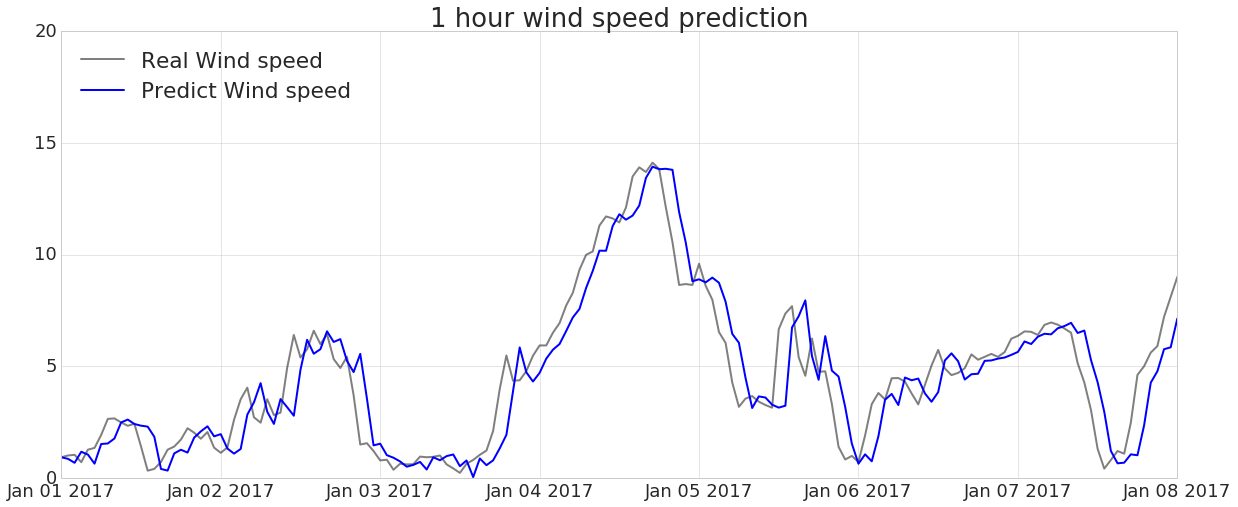

In [8]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18

input1 = df['Time']
output1 = df['xtr3_Wind']
output2 = df['yest3_Wind']

fig = plt.figure() 
ax = plt.axes() 

ylim = [0, 20]
ax.set_ylim(ylim)


plt.plot(input1, output1, lw=2, alpha = 0.5, color="black",label="Real Wind speed") #同じfigureの中に追加
plt.plot(input1, output2, lw=2, alpha = 1, color="blue",label="Predict Wind speed") #同じfigureの中に追加

plt.title("1 hour wind speed prediction")
plt.legend(loc="upper left")
#plt.savefig("graph_modifcation.png")

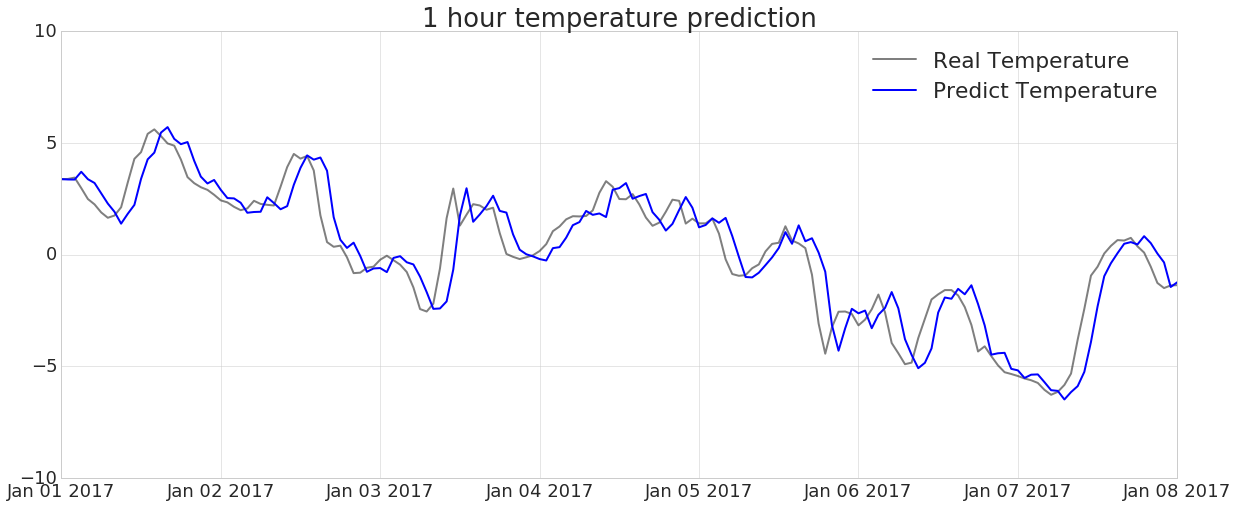

In [9]:
input1 = df['Time']
output1 = df['xtr2_Temp']
output2 = df['yest2_Temp']

fig1 = plt.figure() 
ax1 = plt.axes() 

ylim = [-10, 10]
ax1.set_ylim(ylim)


plt.plot(input1, output1, lw=2, alpha = 0.5, color="black",label="Real Temperature") #同じfigureの中に追加
plt.plot(input1, output2, lw=2, alpha = 1, color="blue",label="Predict Temperature") #同じfigureの中に追加

plt.title("1 hour temperature prediction")
plt.legend(loc="upper right")
#plt.savefig("graph_modifcation.png")